## 프로젝트: 한영 번역기 만들기

## 프로젝트 설명
### Step 1. 데이터 다운로드: korean-english-park.train.tar.gz
### Step 2. 데이터 정제
- 중복된 데이터를 제거
- preprocessing() 함수정의
- 타겟 언어 영문에  start토큰과 end토큰을 추가
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용

### Step 3. 데이터 토큰화
- 단어의 수는 최소 10000이상

### Step 4. 모델 설계
- 한국어를 영어로 잘 번역해 줄 Attention 기반 Seq2seq 모델을 설계
- 모델에 Dropout 모듈을 추가
- Embedding Size와 Hidden Size는 실험을 통해 적절한 값 튜닝

### Step 5. 훈련하기
- attention map 시각화 포함

## 프로젝트 평가
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
- 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. Attentional Seq2seq 모델이 정상적으로 구동된다.
- seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
- 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

## Step 1. 데이터 다운로드

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import time
import re
import os
import io
import random
print(tf.__version__)

2.4.1


In [2]:
# 데이터 다운로드주소 
# https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [3]:
#데이터불러오기 
file_path = os.getenv('HOME')+'/aiffel/lms_project_dataset/GD8'
print(file_path)

/aiffel/aiffel/lms_project_dataset/GD8


In [4]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()
    print("Data Size:", len(raw))
    print("Example:")
    for sen in raw[0:100][::20]: 
        print(">>", sen)
    return raw

In [5]:
raw_kor = load_file('korean-english-park.train.ko')
raw_kor += load_file('korean-english-park.dev.ko')
raw_kor += load_file('korean-english-park.test.ko')
print('total data size:', len(raw_kor))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

In [6]:
raw_en = load_file('korean-english-park.train.en')
raw_en += load_file('korean-english-park.dev.en')
raw_en += load_file('korean-english-park.test.en')
print('total data size:', len(raw_en))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection

In [7]:
print('korean data size:', len(raw_kor))
print('english data size:', len(raw_en))

korean data size: 97123
english data size: 97123


## Step 2. 데이터 정제

In [8]:
# 중복제거1: 한국말 자리에 영어문장이 있는 경우 제거
raw_kor_ = []
raw_en_ = []
for i in range(len(raw_kor)):# 
    if raw_kor[i][:10]==raw_en[i][:10]:
        print(i, raw_kor[i][:10],raw_en[i][:10])
    else:
        raw_kor_.append(raw_kor[i])
        raw_en_.append(raw_en[i])
raw_kor=raw_kor_
raw_en=raw_en_
print(len(raw_kor), len(raw_en))

186 Amazon.com Amazon.com
1067 When times When times
1564 Times Mirr Times Mirr
1656 Compaq, Ap Compaq, Ap
2120 ABC, NBC,  ABC, NBC, 
3843 NTT DoCoMo NTT DoCoMo
4528 Federal Co Federal Co
5101 Starbuck's Starbuck's
5653 Cox Commun Cox Commun
8549 Tools for  Tools for 
9248 The Musica The Musica
9425 I Feel Lik I Feel Lik
10673 Celebrity  Celebrity 
11073 Govsec 200 Govsec 200
11466 The True C The True C
12634 ##http://a ##http://a
13110 The Transf The Transf
13116 Nazi Germa Nazi Germa
13760 The King A The King A
13854 Tips on Ge Tips on Ge
14145 Fight the  Fight the 
14338 Islam, Dem Islam, Dem
17460 ##http://a ##http://a
21075 866/973-74 866/973-74
21103 The Demon  The Demon 
22533 The Comple The Comple
22534 At World's At World's
22959 A First Lo A First Lo
25372 Rocks the  Rocks the 
27568 How a Loui How a Loui
28080 The Autobi The Autobi
28465 A Speech t A Speech t
28911 An Exhibit An Exhibit
30957 tapestries tapestries
30967 ##http://a ##http://a
33385 Paul Inter Paul Inter
34115

In [9]:
# 중복된 데이터를 제거2
raw = zip(raw_kor, raw_en)
raw

In [10]:
set_raw = set(raw)
len(set_raw)

81697

In [11]:
len(set_raw)

81697

In [12]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)

In [13]:
print('korean data size:', len(cleaned_corpus_kor))
print('english data size:', len(cleaned_corpus_eng))

korean data size: 81697
english data size: 81697


In [14]:
cleaned_corpus_kor[0]

'그러나 시간이 지나면 중대한 이해관계에 대한 결정, 끊임없는 비난, 동요하는 여론이 대통령을 서서히 무너뜨린다.'

In [15]:
cleaned_corpus_eng[0]

'But as the years go by, the high-stakes decisions, constant criticisms and the fluctuating public opinion chip away at the president.'

In [16]:
# 한국어전처리: preprocessing() 함수정의
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip() # 소문자 변환
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()
    # 타겟 언어 영문에 start토큰과 end토큰을 추가
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    return sentence

In [17]:
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    print("kor:", kor)
    print("eng:", eng)
    break

kor: 그러나 시간이 지나면 중대한 이해관계에 대한 결정, 끊임없는 비난, 동요하는 여론이 대통령을 서서히 무너뜨린다.
eng: But as the years go by, the high-stakes decisions, constant criticisms and the fluctuating public opinion chip away at the president.


In [18]:
# 토큰길이 40이하인 데이터 
enc_corpus = []
dec_corpus = []

# num_examples = 30000
cnt=0
for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

    if len(temp_kor) <= 40:
        enc_corpus.append(temp_kor)
        dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[100])   
print("English:", dec_corpus[100])

korean data size: 17026
english data size: 17026
Korean: 이에앞서 상원은 일 찬성 반대 로 가결처리했다 .
English: <start> the senate approved the measure late thursday by and the white house said the president would sign the bill . <end>


In [19]:
print("Korean:", enc_corpus[0])   
print("English:", dec_corpus[0])

Korean: 만약 우리가 우리의 입지와 브랜드명을 확립하지 못하면 우리는 죽습니다 .
English: <start> if we can t establish presence and a brand name we ll die . <end>


In [20]:
print("Korean:", cleaned_corpus_kor[10])   
print("English:", cleaned_corpus_eng[10])

Korean: 만약 우리가 우리의 입지와 브랜드명을 확립하지 못하면 우리는 죽습니다."
English: If we can't establish presence and a brand name, we'll die."


## Step 3. 데이터 토큰화
- 단어의 수는 최소 10000이상

In [21]:
# 한글 토큰화는 KoNLPy의 mecab 클래스를 사용
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [22]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 41749
English Vocab Size: 17312


## Step 4. 모델 설계
- 한국어를 영어로 잘 번역해 줄 Attention 기반 Seq2seq 모델을 설계
- 모델에 Dropout 모듈을 추가
- Embedding Size와 Hidden Size는 실험을 통해 적절한 값 튜닝

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [26]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 17313)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [28]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [29]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


## Step 5. 훈련하기
- attention map 시각화 포함

In [30]:
# Training Process
from tqdm import tqdm

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 50: 100%|██████████| 54/54 [00:25<00:00,  2.10it/s, Test Loss 2.4549]


In [31]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [32]:
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

Input: 이쪽은 내고향이야 .
Predicted translation: . the orphanage juan antonio bayona <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


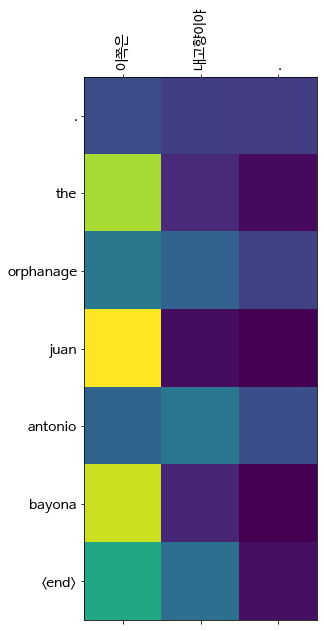

In [33]:
# 예시
translate("이쪽은 내고향이야.", encoder, decoder)

Input: 연어는 물고기다 .
Predicted translation: . the orphanage juan antonio bayona <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


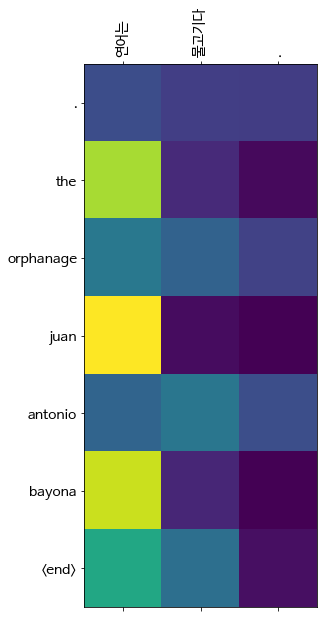

In [34]:
# 예시
translate("연어는 물고기다.", encoder, decoder)

Input: 오늘은 코로나 확진자 수가 명이 넘었다 .
Predicted translation: it was more than half blood . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


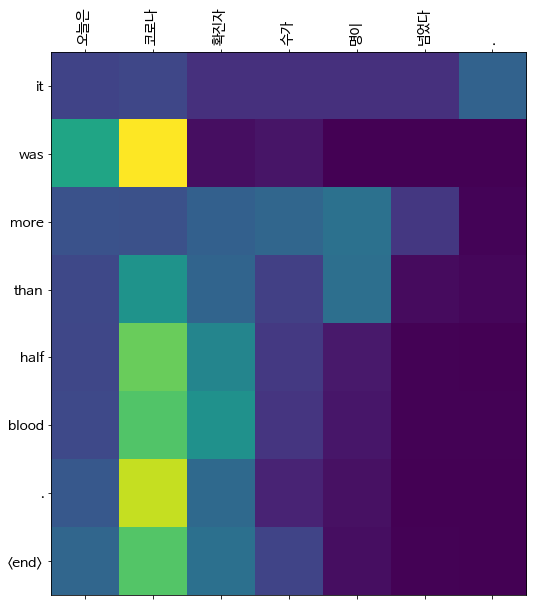

In [35]:
# 예시
translate("오늘은 코로나 확진자 수가 1000명이 넘었다.", encoder, decoder)

Input: 오늘밤은 달이 밝은 날이다 .
Predicted translation: this it can see this . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


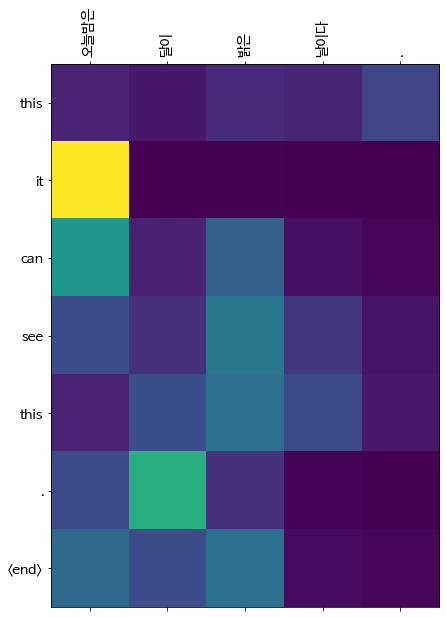

In [36]:
# 예시
translate("오늘밤은 달이 밝은 날이다.", encoder, decoder)

## 프로젝트 정리
- 데이터셋 자체가 가진 문제점을 발견하여 수정하였음. 단순한 중복 케이스도 있지만, 한국어 문장이 있어야 할 자리에 타켓 영어문장의 일부분이 쓰여있는 것을 발견하였다. 이러한 중복도 제거를 하였음. 
- 모델구조의 전반적인 흐름을 이해할 수 있었고, mecab을 이용한 토큰화하는 부분도 추가 공부할 수 있는 기회가 되었다.
- voca size나 embedding_dim등을 수정해보았고, 전반적으로 원하는 성과보다는 잘 나오지 못하였다. 